In [82]:
import os
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import matplotlib.pyplot as plt
import warnings

# 경고 메시지 무시
warnings.filterwarnings('ignore')

# 가상 환경에서 발생하는 라이브러리 중복 로드 문제 해결
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# 재현성을 위한 시드 고정
torch.manual_seed(42)
np.random.seed(42)

# Matplotlib 스타일 설정
plt.style.use("seaborn-v0_8")

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [83]:
# 상수 정의
DATA_ROOT = Path("cleaned_dataset")
META_PATH = DATA_ROOT / "metadata.csv"
SEQ_LEN = 120
FEATURE_COLS = [
    "Voltage_measured",
    "Current_measured",
    "Temperature_measured",
    "Current_load",
    "Voltage_load",
]

def load_cycle_sequence(filename: str, seq_len: int = SEQ_LEN) -> np.ndarray:
    """각 사이클 데이터를 고정된 길이(seq_len)의 시퀀스로 보간합니다."""
    path = DATA_ROOT / "data" / filename
    df = pd.read_csv(path).sort_values("Time")
    time = df["Time"].values
    new_time = np.linspace(time.min(), time.max(), seq_len)
    interpolated = [np.interp(new_time, time, df[col].values) for col in FEATURE_COLS]
    return np.stack(interpolated, axis=1)

class CycleDataset(Dataset):
    """PyTorch용 배터리 사이클 데이터셋 클래스입니다."""
    def __init__(self, sequences: np.ndarray, targets: np.ndarray):
        self.x = torch.from_numpy(sequences).float()
        self.y = torch.from_numpy(targets).float()

    def __len__(self) -> int:
        return len(self.x)

    def __getitem__(self, idx: int):
        return self.x[idx], self.y[idx]

In [84]:
class LSTMRegressor(nn.Module):
    """LSTM 기반 SOH 회귀 모델 클래스입니다."""
    def __init__(self, input_size: int, hidden_size: int = 64, num_layers: int = 2, dropout: float = 0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        output, (hn, _) = self.lstm(x)
        # 마지막 타임스텝의 마지막 레이어 히든 상태를 사용
        last_hidden = hn[-1]
        prediction = self.fc(last_hidden)
        return prediction.squeeze(-1)

In [85]:
def train_and_evaluate(train_loader, val_loader, input_size, epochs=25, lr=1e-3):
    """모델을 학습하고 최적의 모델 상태와 검증 RMSE를 반환합니다."""
    model = LSTMRegressor(input_size=input_size).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    best_val_loss = float("inf")
    best_state = None

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                loss = criterion(preds, yb)
                val_loss += loss.item() * xb.size(0)
        
        val_loss /= len(val_loader.dataset)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = model.state_dict()

    # 최적 모델로 예측 수행
    model.load_state_dict(best_state)
    
    preds_list, targets_list = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            preds_batch = model(xb).cpu().numpy()
            preds_list.append(preds_batch)
            targets_list.append(yb.numpy())
            
    preds = np.concatenate(preds_list)
    targets = np.concatenate(targets_list)
    
    rmse = np.sqrt(np.mean((preds - targets) ** 2))
    
    return preds, targets, rmse

In [86]:
# 실험 파라미터
BATTERY_IDS = ["B0005", "B0006", "B0007", "B0018"]
N_SPLITS_VALUES = [1, 5, 10]
TRAIN_RATIO = 0.8
BATCH_SIZE = 16
EPOCHS = 25

meta_df = pd.read_csv(META_PATH)
results = {}

for battery_id in BATTERY_IDS:
    print(f"========== Processing Battery: {battery_id} ==========")
    results[battery_id] = []

    # 1. 배터리 데이터 로드 및 전처리
    battery_meta = meta_df[(meta_df["type"] == "discharge") & (meta_df["battery_id"] == battery_id)].sort_values("start_time").reset_index(drop=True)
    battery_meta["Capacity"] = pd.to_numeric(battery_meta["Capacity"], errors="coerce")
    battery_meta["cycle_index"] = np.arange(len(battery_meta))
    battery_meta["soh"] = battery_meta["Capacity"] / battery_meta["Capacity"].iloc[0]
    
    sequences = np.stack([load_cycle_sequence(fn) for fn in battery_meta["filename"]], axis=0)
    targets = battery_meta["soh"].values
    total_cycles = len(sequences)

    for n_splits in N_SPLITS_VALUES:
        print(f"----- N_SPLITS = {n_splits} -----")
        
        # 2. 데이터 분할 (Stratified Split)
        split_size = total_cycles // n_splits
        train_indices, val_indices = [], []
        for i in range(n_splits):
            start_idx = i * split_size
            end_idx = (i + 1) * split_size if i < n_splits - 1 else total_cycles
            segment_indices = np.arange(start_idx, end_idx)
            segment_train_size = int(len(segment_indices) * TRAIN_RATIO)
            train_indices.extend(segment_indices[:segment_train_size])
            val_indices.extend(segment_indices[segment_train_size:])

        train_X, val_X = sequences[train_indices], sequences[val_indices]
        train_y, val_y = targets[train_indices], targets[val_indices]
        val_meta_loop = battery_meta.iloc[val_indices].copy()

        # 3. 정규화
        flat_train = train_X.reshape(-1, len(FEATURE_COLS))
        mean, std = flat_train.mean(axis=0), flat_train.std(axis=0) + 1e-6
        train_X_norm = (train_X - mean) / std
        val_X_norm = (val_X - mean) / std

        # 4. 데이터로더 생성
        train_dataset = CycleDataset(train_X_norm, train_y)
        val_dataset = CycleDataset(val_X_norm, val_y)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

        # 5. 학습 및 평가
        val_preds, val_targets, val_rmse = train_and_evaluate(train_loader, val_loader, input_size=len(FEATURE_COLS), epochs=EPOCHS)
        print(f"Validation RMSE: {val_rmse:.4f}")

        # 6. 결과 저장
        results[battery_id].append({
            "n_splits": n_splits,
            "rmse": val_rmse,
            "cycle_index": val_meta_loop["cycle_index"].values,
            "true_soh": val_targets,
            "pred_soh": val_preds,
        })
print("\n========== All experiments finished. ==========")

========== Processing Battery: B0005 ==========
----- N_SPLITS = 1 -----
Validation RMSE: 0.0110
----- N_SPLITS = 5 -----
Validation RMSE: 0.0127
----- N_SPLITS = 10 -----
Validation RMSE: 0.0161
========== Processing Battery: B0006 ==========
----- N_SPLITS = 1 -----
Validation RMSE: 0.0123
----- N_SPLITS = 5 -----
Validation RMSE: 0.0146
----- N_SPLITS = 10 -----
Validation RMSE: 0.0186
========== Processing Battery: B0007 ==========
----- N_SPLITS = 1 -----
Validation RMSE: 0.0087
----- N_SPLITS = 5 -----
Validation RMSE: 0.0172
----- N_SPLITS = 10 -----
Validation RMSE: 0.0246
========== Processing Battery: B0018 ==========
----- N_SPLITS = 1 -----
Validation RMSE: 0.0443
----- N_SPLITS = 5 -----
Validation RMSE: 0.0385
----- N_SPLITS = 10 -----
Validation RMSE: 0.0284

========== All experiments finished. ==========


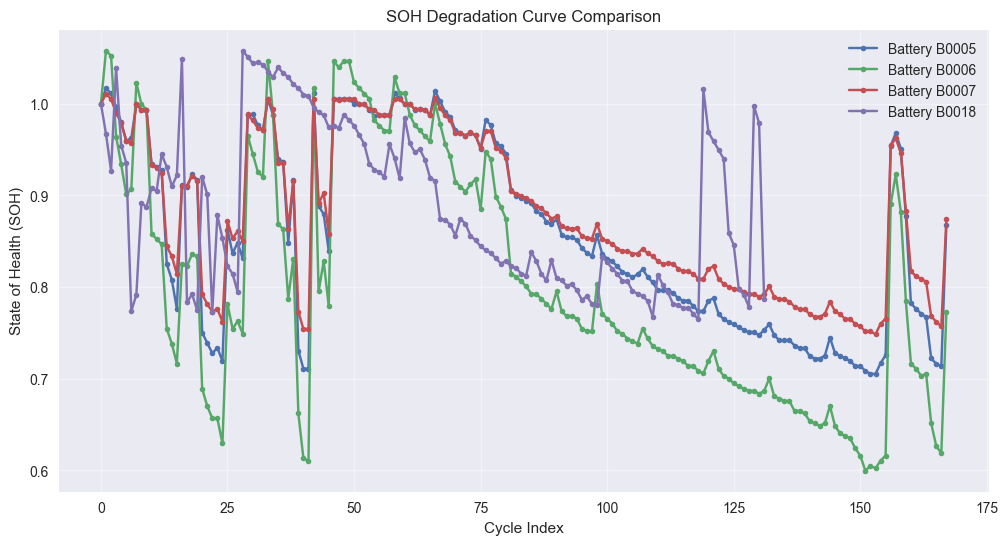

In [87]:
# 각 배터리별 SOH 감소 추이 시각화
BATTERY_IDS_FOR_VIZ = ["B0005", "B0006", "B0007", "B0018"]
meta_df_viz = pd.read_csv(META_PATH)

# 하나의 그래프를 생성
fig, ax = plt.subplots(figsize=(12, 6))

for battery_id in BATTERY_IDS_FOR_VIZ:
    
    # 배터리 데이터 로드 및 전처리
    battery_meta_to_plot = meta_df_viz[(meta_df_viz["type"] == "discharge") & (meta_df_viz["battery_id"] == battery_id)].sort_values("start_time").reset_index(drop=True)
    battery_meta_to_plot["Capacity"] = pd.to_numeric(battery_meta_to_plot["Capacity"], errors="coerce")
    battery_meta_to_plot["cycle_index"] = np.arange(len(battery_meta_to_plot))
    battery_meta_to_plot["soh"] = battery_meta_to_plot["Capacity"] / battery_meta_to_plot["Capacity"].iloc[0]

    # 현재 그래프에 배터리 SOH 곡선 추가
    ax.plot(battery_meta_to_plot["cycle_index"], battery_meta_to_plot["soh"], marker='o', markersize=4, linestyle='-', label=f"Battery {battery_id}")

# 그래프 공통 설정
ax.set_xlabel("Cycle Index")
ax.set_ylabel("State of Health (SOH)")
ax.set_title("SOH Degradation Curve Comparison")
ax.grid(True, alpha=0.4)
ax.legend()
plt.show()

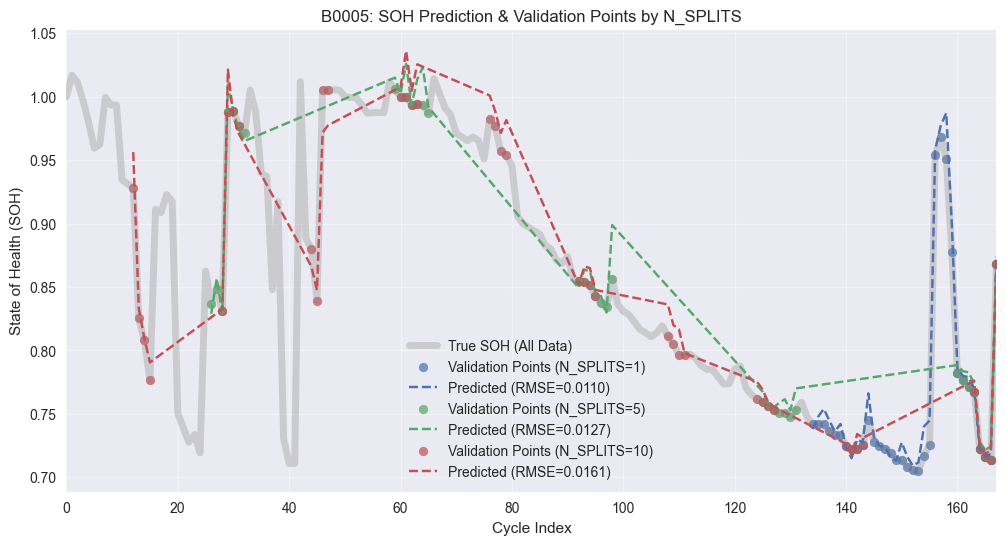

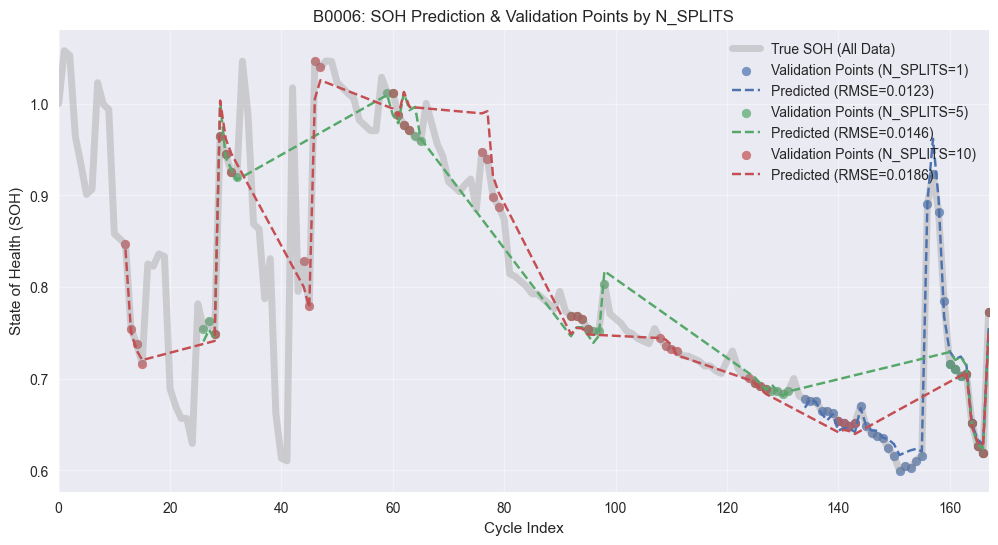

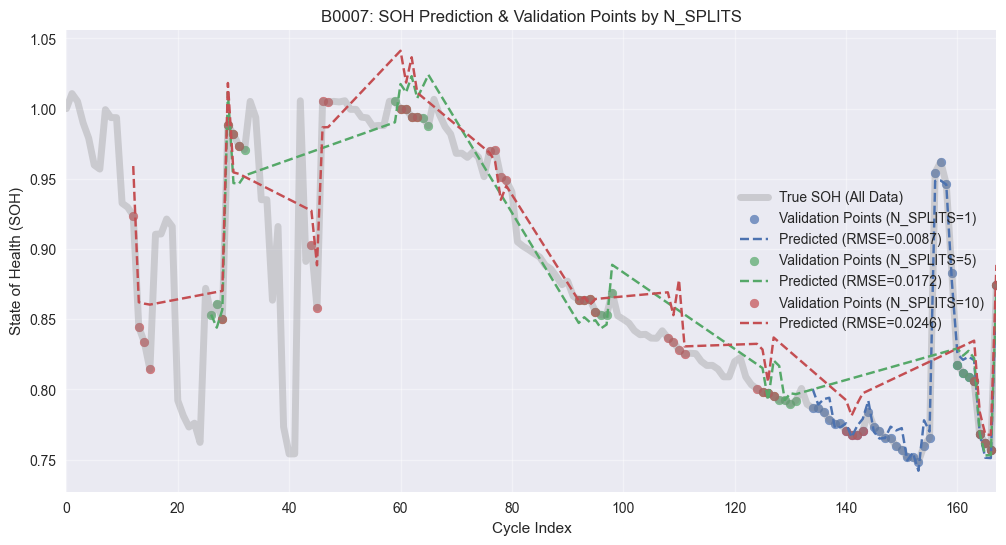

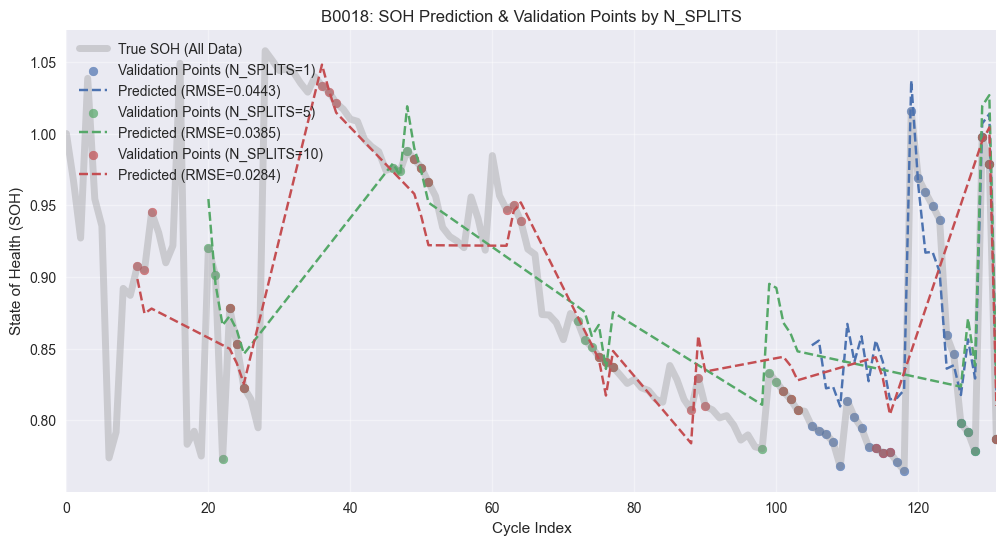

In [88]:
# 1. 배터리별 SOH 예측 결과 시각화
for battery_id, battery_results in results.items():
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # 전체 데이터의 실제 SOH를 배경으로 플롯
    battery_meta = meta_df[(meta_df["type"] == "discharge") & (meta_df["battery_id"] == battery_id)].sort_values("start_time").reset_index(drop=True)
    battery_meta["Capacity"] = pd.to_numeric(battery_meta["Capacity"], errors="coerce")
    battery_meta["cycle_index"] = np.arange(len(battery_meta))
    battery_meta["soh"] = battery_meta["Capacity"] / battery_meta["Capacity"].iloc[0]
    ax.plot(battery_meta["cycle_index"], battery_meta["soh"], label="True SOH (All Data)", color='gray', linewidth=5, alpha=0.3)

    # N_SPLITS별 예측 결과 및 검증 데이터 위치 플롯
    # 색상 사이클을 수동으로 관리하여 예측선과 검증 포인트 색상을 맞춤
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    
    for i, result in enumerate(battery_results):
        color = colors[i % len(colors)]
        
        # cycle_index를 기준으로 정렬
        sorted_indices = np.argsort(result["cycle_index"])
        cycle_index_sorted = result["cycle_index"][sorted_indices]
        pred_soh_sorted = result["pred_soh"][sorted_indices]
        true_soh_sorted = result["true_soh"][sorted_indices]

        # 1. 검증 데이터의 실제 위치를 산점도로 표시
        ax.scatter(
            cycle_index_sorted, 
            true_soh_sorted, 
            marker='o',
            s=40, # 마커 크기
            color=color,
            label=f'Validation Points (N_SPLITS={result["n_splits"]})',
            alpha=0.7
        )
        
        # 2. 모델의 예측 결과를 점선으로 표시
        ax.plot(
            cycle_index_sorted, 
            pred_soh_sorted, 
            linestyle='--',
            color=color,
            label=f'Predicted (RMSE={result["rmse"]:.4f})'
        )

    ax.set_xlabel("Cycle Index")
    ax.set_ylabel("State of Health (SOH)")
    ax.set_title(f"{battery_id}: SOH Prediction & Validation Points by N_SPLITS")
    ax.grid(True, alpha=0.4)
    ax.set_xlim(0, len(battery_meta) - 1)
    ax.legend()
    plt.show()

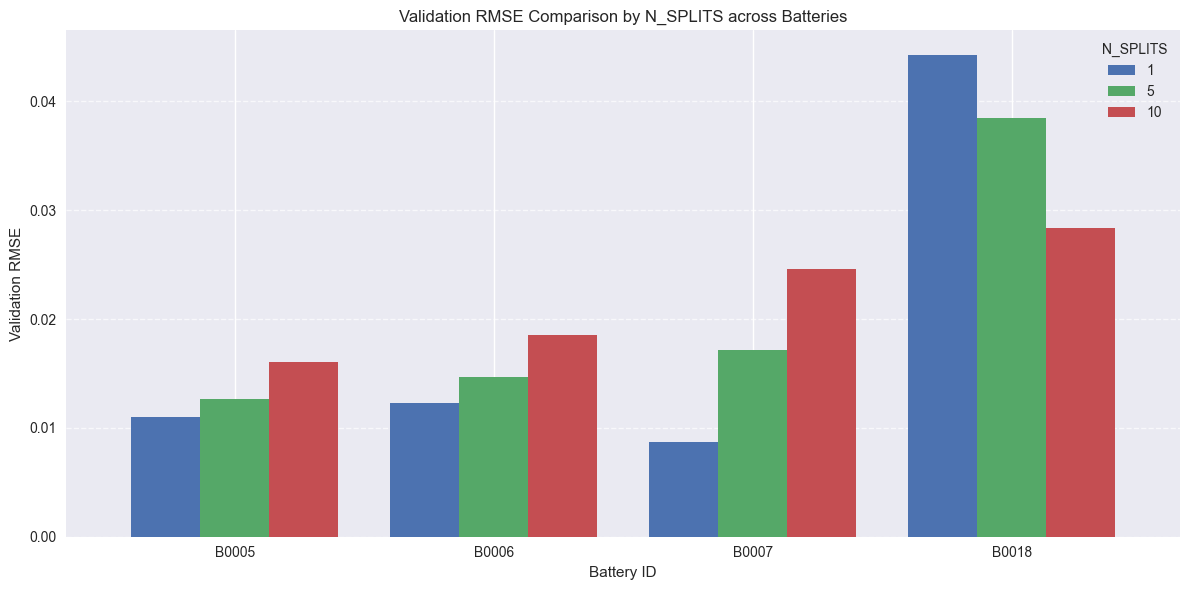

In [89]:
# 2. 배터리별 N_SPLITS에 따른 RMSE 비교 막대 그래프
rmse_df = pd.DataFrame([
    {"battery_id": bid, "n_splits": r["n_splits"], "rmse": r["rmse"]}
    for bid, b_results in results.items()
    for r in b_results
])

fig, ax = plt.subplots(figsize=(12, 6))
pivot_df = rmse_df.pivot(index="battery_id", columns="n_splits", values="rmse")
pivot_df.plot(kind='bar', ax=ax, width=0.8)

ax.set_xlabel("Battery ID")
ax.set_ylabel("Validation RMSE")
ax.set_title("Validation RMSE Comparison by N_SPLITS across Batteries")
ax.tick_params(axis='x', rotation=0)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.legend(title="N_SPLITS")
plt.tight_layout()
plt.show()

In [90]:
# 가설 검증: "cycle_index가 증가함에 따라 SOH는 감소해야 한다"
# cycle_index 50을 기준으로 before/after 위반 횟수를 계산합니다.

BATTERY_IDS_TO_CHECK = ["B0005", "B0006", "B0007", "B0018"]
meta_df_check = pd.read_csv(META_PATH)
SPLIT_CYCLE = 50

print(f"===== SOH 비단조적 증가 검사 (기준: cycle_index {SPLIT_CYCLE}) =====")

for battery_id in BATTERY_IDS_TO_CHECK:
    # 1. 배터리 데이터 로드 및 전처리
    battery_meta_check = (
        meta_df_check[
            (meta_df_check["type"] == "discharge") & 
            (meta_df_check["battery_id"] == battery_id)
        ]
        .sort_values("start_time")
        .reset_index(drop=True)
    )
    
    battery_meta_check["Capacity"] = pd.to_numeric(battery_meta_check["Capacity"], errors="coerce")
    battery_meta_check["cycle_index"] = np.arange(len(battery_meta_check))
    battery_meta_check["soh"] = battery_meta_check["Capacity"] / battery_meta_check["Capacity"].iloc[0]
    
    # 2. SOH 값의 차이를 계산하여 SOH가 증가한 지점을 찾음
    violations = battery_meta_check["soh"].diff() > 0
    
    # 3. cycle_index 50을 기준으로 before/after 위반 횟수 계산
    # .loc[]를 사용하여 조건에 맞는 행을 선택하고, 그 개수를 셉니다.
    before_violations = violations.loc[battery_meta_check["cycle_index"] <= SPLIT_CYCLE].sum()
    after_violations = violations.loc[battery_meta_check["cycle_index"] > SPLIT_CYCLE].sum()
    
    total_cycles = len(battery_meta_check)
    
    print(f"배터리 ID: {battery_id}")
    print(f" - 전체 사이클 수: {total_cycles}")
    print(f" - Before (cycle <= {SPLIT_CYCLE}) 위반 횟수: {before_violations} 회")
    print(f" - After (cycle > {SPLIT_CYCLE}) 위반 횟수: {after_violations} 회")
    print(f" - 총 위반 횟수: {before_violations + after_violations} 회")
    print("-" * 30)

===== SOH 비단조적 증가 검사 (기준: cycle_index 50) =====
배터리 ID: B0005
 - 전체 사이클 수: 168
 - Before (cycle <= 50) 위반 횟수: 16 회
 - After (cycle > 50) 위반 횟수: 31 회
 - 총 위반 횟수: 47 회
------------------------------
배터리 ID: B0006
 - 전체 사이클 수: 168
 - Before (cycle <= 50) 위반 횟수: 14 회
 - After (cycle > 50) 위반 횟수: 25 회
 - 총 위반 횟수: 39 회
------------------------------
배터리 ID: B0007
 - 전체 사이클 수: 168
 - Before (cycle <= 50) 위반 횟수: 18 회
 - After (cycle > 50) 위반 횟수: 34 회
 - 총 위반 횟수: 52 회
------------------------------
배터리 ID: B0018
 - 전체 사이클 수: 132
 - Before (cycle <= 50) 위반 횟수: 15 회
 - After (cycle > 50) 위반 횟수: 14 회
 - 총 위반 횟수: 29 회
------------------------------


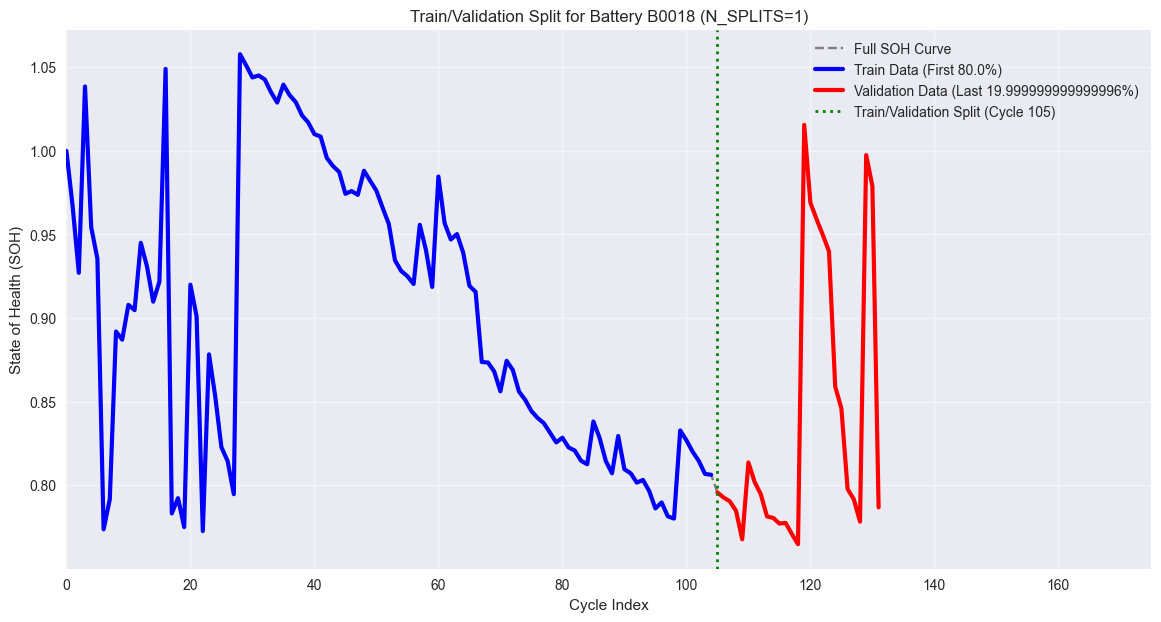

In [91]:
# B0018 배터리의 N_SPLITS=1 경우 학습/검증 구간 시각화

battery_id_check = "B0018"
train_ratio_check = 0.8

# 1. 데이터 로드 및 SOH 계산
b_meta = meta_df[(meta_df["type"] == "discharge") & (meta_df["battery_id"] == battery_id_check)].sort_values("start_time").reset_index(drop=True)
b_meta["Capacity"] = pd.to_numeric(b_meta["Capacity"], errors="coerce")
b_meta["cycle_index"] = np.arange(len(b_meta))
b_meta["soh"] = b_meta["Capacity"] / b_meta["Capacity"].iloc[0]

# 2. 학습/검증 데이터 분할 지점 계산
total_cycles_check = len(b_meta)
split_point = int(total_cycles_check * train_ratio_check)

train_df = b_meta.iloc[:split_point]
val_df = b_meta.iloc[split_point:]

# 3. 시각화
fig, ax = plt.subplots(figsize=(14, 7))

# 전체 SOH 플롯
ax.plot(b_meta["cycle_index"], b_meta["soh"], color='gray', linestyle='--', label='Full SOH Curve')

# 학습 데이터 구간 플롯
ax.plot(train_df["cycle_index"], train_df["soh"], color='blue', linewidth=3, label=f'Train Data (First {train_ratio_check*100}%)')

# 검증 데이터 구간 플롯
ax.plot(val_df["cycle_index"], val_df["soh"], color='red', linewidth=3, label=f'Validation Data (Last {(1-train_ratio_check)*100}%)')

# 분할 지점 수직선으로 표시
ax.axvline(x=split_point, color='green', linestyle=':', linewidth=2, label=f'Train/Validation Split (Cycle {split_point})')

ax.set_xlabel("Cycle Index")
ax.set_ylabel("State of Health (SOH)")
ax.set_title(f"Train/Validation Split for Battery {battery_id_check} (N_SPLITS=1)")
ax.legend()
ax.set_xlim(0, 175)
ax.grid(True, alpha=0.5)
plt.show()

===== DTW Distance Matrix =====
          B0005      B0006      B0007      B0018
B0005  0.000000   7.490073   2.269910   5.742371
B0006  7.490073   0.000000  10.044860  10.603793
B0007  2.269910  10.044860   0.000000   4.406369
B0018  5.742371  10.603793   4.406369   0.000000

*거리가 작을수록 두 SOH 곡선의 패턴이 더 유사합니다.


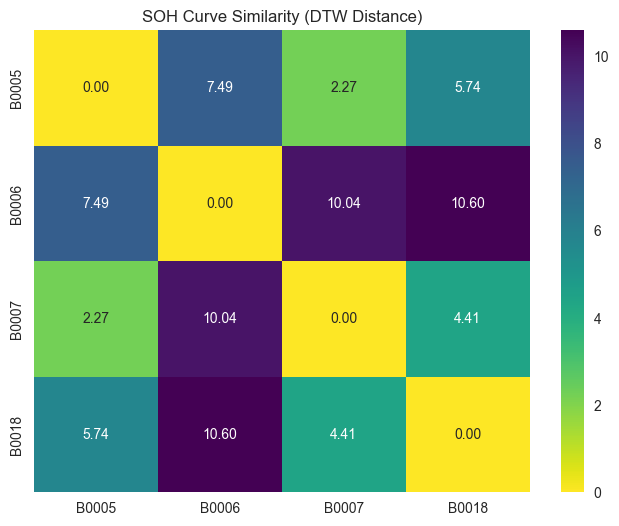

In [92]:
from dtw import dtw
import seaborn as sns

# 1. 각 배터리의 SOH 시계열 데이터 준비
BATTERY_IDS_FOR_DTW = ["B0005", "B0006", "B0007", "B0018"]
soh_series = {}

for battery_id in BATTERY_IDS_FOR_DTW:
    b_meta = meta_df[(meta_df["type"] == "discharge") & (meta_df["battery_id"] == battery_id)].sort_values("start_time").reset_index(drop=True)
    b_meta["Capacity"] = pd.to_numeric(b_meta["Capacity"], errors="coerce")
    b_meta["soh"] = b_meta["Capacity"] / b_meta["Capacity"].iloc[0]
    # SOH 값만 numpy 배열로 저장
    soh_series[battery_id] = b_meta["soh"].values

# 2. 모든 배터리 쌍에 대해 DTW 거리 계산
battery_ids = list(soh_series.keys())
num_batteries = len(battery_ids)
dtw_distances = pd.DataFrame(np.zeros((num_batteries, num_batteries)), index=battery_ids, columns=battery_ids)

for i in range(num_batteries):
    for j in range(i, num_batteries):
        id1 = battery_ids[i]
        id2 = battery_ids[j]
        
        # dtw 라이브러리를 사용하여 거리 계산
        # keep_internals=True는 시각화를 위해 필요할 수 있으나, 여기서는 거리만 계산
        distance = dtw(soh_series[id1], soh_series[id2]).distance
        
        # 대칭 행렬이므로 양쪽에 값을 채움
        dtw_distances.loc[id1, id2] = distance
        dtw_distances.loc[id2, id1] = distance

print("===== DTW Distance Matrix =====")
print(dtw_distances)
print("\n*거리가 작을수록 두 SOH 곡선의 패턴이 더 유사합니다.")

# 3. DTW 거리를 히트맵으로 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(dtw_distances, annot=True, fmt=".2f", cmap="viridis_r") # _r은 색상 반전 (낮은 값이 진하게)
plt.title("SOH Curve Similarity (DTW Distance)")
plt.show()

각 배터리의 전체 수명 주기를 100개의 점으로 정규화하여 재구성합니다.

===== DTW Distance Matrix (Normalized X-axis) =====
          B0005     B0006     B0007     B0018
B0005  0.000000  4.202354  1.544849  3.810624
B0006  4.202354  0.000000  5.700366  6.434477
B0007  1.544849  5.700366  0.000000  2.862977
B0018  3.810624  6.434477  2.862977  0.000000

*거리가 작을수록 두 SOH 곡선의 전체적인 '모양'이 더 유사합니다.


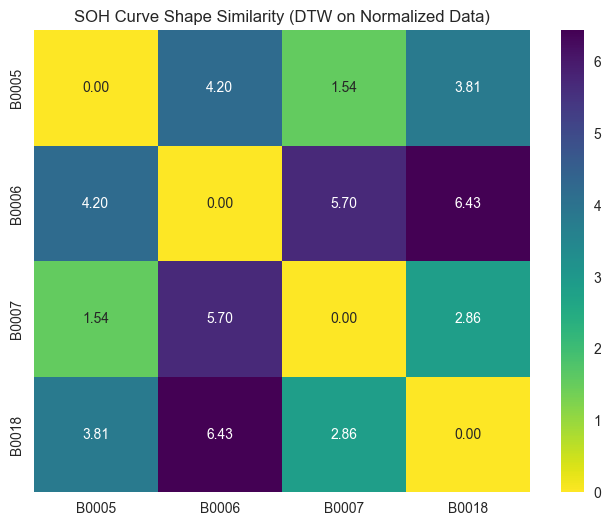

In [93]:
from dtw import dtw
import seaborn as sns
import numpy as np

# 1. 각 배터리의 SOH 시계열 데이터 준비
BATTERY_IDS_FOR_DTW = ["B0005", "B0006", "B0007", "B0018"]
soh_series_original = {}

for battery_id in BATTERY_IDS_FOR_DTW:
    b_meta = meta_df[(meta_df["type"] == "discharge") & (meta_df["battery_id"] == battery_id)].sort_values("start_time").reset_index(drop=True)
    b_meta["Capacity"] = pd.to_numeric(b_meta["Capacity"], errors="coerce")
    b_meta["soh"] = b_meta["Capacity"] / b_meta["Capacity"].iloc[0]
    soh_series_original[battery_id] = b_meta["soh"].values

# 1-1. X축 정규화 및 보간 (Resampling)
# 모든 시계열을 동일한 길이(예: 100개 점)로 재구성하여 전체 수명 주기의 '모양'을 비교
NUM_POINTS = 100 
soh_series_resampled = {}
target_x = np.linspace(0, 1, NUM_POINTS) # 0~1 사이의 100개 지점

print(f"각 배터리의 전체 수명 주기를 {NUM_POINTS}개의 점으로 정규화하여 재구성합니다.")

for bid, series in soh_series_original.items():
    # 각 배터리의 원래 X축 (0~1로 정규화)
    original_x = np.linspace(0, 1, len(series))
    # target_x 지점에 해당하는 SOH 값을 보간하여 계산
    resampled_series = np.interp(target_x, original_x, series)
    soh_series_resampled[bid] = resampled_series

# 2. 모든 배터리 쌍에 대해 DTW 거리 계산 (재구성된 데이터 사용)
battery_ids = list(soh_series_resampled.keys())
num_batteries = len(battery_ids)
dtw_distances = pd.DataFrame(np.zeros((num_batteries, num_batteries)), index=battery_ids, columns=battery_ids)

for i in range(num_batteries):
    for j in range(i, num_batteries):
        id1 = battery_ids[i]
        id2 = battery_ids[j]
        
        distance = dtw(soh_series_resampled[id1], soh_series_resampled[id2]).distance
        
        dtw_distances.loc[id1, id2] = distance
        dtw_distances.loc[id2, id1] = distance

print("\n===== DTW Distance Matrix (Normalized X-axis) =====")
print(dtw_distances)
print("\n*거리가 작을수록 두 SOH 곡선의 전체적인 '모양'이 더 유사합니다.")

# 3. DTW 거리를 히트맵으로 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(dtw_distances, annot=True, fmt=".2f", cmap="viridis_r")
plt.title("SOH Curve Shape Similarity (DTW on Normalized Data)")
plt.show()